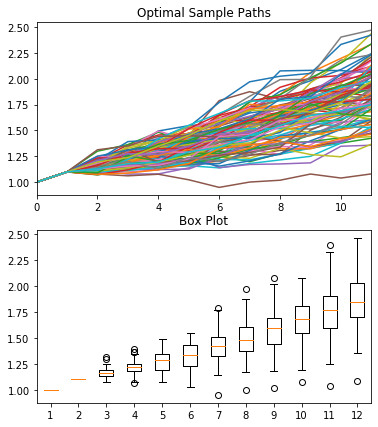

In [1]:
import numpy as np
from scipy.optimize import fminbound
import matplotlib.pyplot as plt

r = 0.1
β = 1/(1+r)
γ = 0.5
T = 10
M = 100             # number of sample paths

grid_max = 30       # Largest grid point
grid_size = 200     # Number of grid points
shock_size = 100    # Number of shock draws in Monte Carlo integral

grid = np.linspace(1e-5, grid_max, grid_size)
shocks = np.zeros(shape=(shock_size,T))
for i in range(0,shock_size):
    shocks[i,:]=np.exp(0.05+0.05*np.random.randn(T))

#np.random.lognormal(0.05,0.01,shock_size)

def ForwardPass(c_star):
    consumption=lambda xvals,ygrid: np.interp(xvals,grid,ygrid)
    a=np.ones(T+2)
    y=np.ones(T+2)
    a[0]=1
    y[0]=1
    psi = np.random.lognormal(0.05,0.05,T+1)
    for t in np.arange(T+1):
        a[t+1]=(1+r)*a[t]+y[t]-consumption(a[t],c_star[t])
        y[t+1]=psi[t]*y[t]
    return a    
    
    
# Approximate Backward Recursion    

c_star=np.zeros([T+1,grid_size])
v_star=np.zeros([T+1,grid_size])
v_func = lambda x,y: np.interp(x, grid, y)
cum_shock = np.ones(shock_size)

for t in np.arange(T,-1,-1):
    
    if t==T:
        for i,a in enumerate(grid):
            objective = lambda c: -(c**(1-γ))/(1-γ)
            c_star[-1,i]=fminbound(objective,0,a)
            v_star[-1,i]=-objective(c_star[-1,i])
    else:
        for j in range(0,shock_size):
            for i in range(0,t-1):
                cum_shock[j] = np.multiply(shocks[j,i],cum_shock[j])           
            
        for i,a in enumerate(grid):
            objective = lambda c: -(c**(1-γ))/(1-γ)-β*np.mean(v_func((1+r)*a+cum_shock-c,v_star[t+1,:]))
            c_star[t,i]=fminbound(objective,0,a)
            v_star[t,i]=-objective(c_star[-1,i])


# Simulation of optimal paths

SamplePaths=np.zeros([M,T+2])
for i in range(M):
    SamplePaths[i,:]=ForwardPass(c_star)

fig,ax = plt.subplots(2,1,figsize=(6,7))

for i in range(M):
    ax[0].plot(SamplePaths[i])
ax[0].set_xlim([0,T+1])
ax[0].set_title("Optimal Sample Paths")

ax[1].boxplot(SamplePaths)
ax[1].set_title("Box Plot")
plt.show()
